In [2]:
import numpy as np
import pandas as pd
from functions import loadMultiParquet, cut, getXSectionBR
from helpersForNN import preprocessMultiClass, scale, unscale
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import mplhep as hep
hep.style.use("CMS")
import sys, os, glob, re
import math
from applyMultiClass_Hpeak import getPredictions, splitPtFunc

In [7]:
pTClass, nReal, nMC = 0, 90, -1
paths = [
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/Data1A/others",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/GluGluHToBB/others",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-100to200",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-200to400",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-400to600",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-600to800",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-800toInf"
            ]

pathToPredictions = "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/NNpredictions"
# check for which fileNumbers the predictions is available
isMCList = [0, 1,36, 20, 21, 22, 23]
fileNumberList = []
for isMC in isMCList:
    fileNumberProcess = []
    fileNamesProcess = glob.glob(pathToPredictions+"/yMC%d_fn*pt%d*.parquet"%(isMC, pTClass))
    for fileName in fileNamesProcess:
        match = re.search(r'_fn(\d+)_pt', fileName)
        if match:
            fn = match.group(1)
            fileNumberProcess.append(int(fn))
            
        else:
            pass
            #print("Number not found")
    fileNumberList.append(fileNumberProcess)
    print(len(fileNumberProcess), " predictions files for process MC : ", isMC)


# load the files where the prediction is available
columns = None # ['sf', 'dijet_mass', 'dijet_pt', 'jet1_pt', 'jet2_pt','jet1_mass', 'jet2_mass', 'jet1_eta', 'jet2_eta', 'jet1_qgl', 'jet2_qgl']
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=-1, columns=columns, returnNumEventsTotal=True, selectFileNumberList=fileNumberList, returnFileNumberList=True)
pTmin, pTmax, suffix = [[0,-1,'inclusive'], [0, 30, 'lowPt'], [30, 100, 'mediumPt'], [100, -1, 'highPt']][pTClass]    
dfs = preprocessMultiClass(dfs, pTmin, pTmax, suffix)   # get the dfs with the cut in the pt class


944  predictions files for process MC :  0
154  predictions files for process MC :  1
1580  predictions files for process MC :  36
162  predictions files for process MC :  20
249  predictions files for process MC :  21
241  predictions files for process MC :  22
210  predictions files for process MC :  23
Looking for a specific list of  944  files expected
Found 90 files for process 0
90 files for process 0


Looking for a specific list of  154  files expected
Found 154 files for process 1
154 files for process 1


Looking for a specific list of  1580  files expected
Found 304 files for process 2
304 files for process 2


Looking for a specific list of  162  files expected
Found 110 files for process 3
110 files for process 3


Looking for a specific list of  249  files expected
Found 110 files for process 4
110 files for process 4


Looking for a specific list of  241  files expected
Found 110 files for process 5
110 files for process 5


Looking for a specific list of  210  files exp

In [8]:
minPt, maxPt = None, None #180, -1
if (minPt is not None) | (maxPt is not None):
    dfs, masks = splitPtFunc(dfs, minPt, maxPt)
    splitPt = True
else:
    masks=None
    splitPt=False
        
W = dfs[0].sf
W_H = dfs[1].sf*getXSectionBR()/numEventsList[1]*nReal*0.774/1017*1000
W_1 = 5.261e+03/numEventsList[2]*dfs[2].sf*nReal*0.774/1017*1000
W_2 = 1012./numEventsList[3]*dfs[3].sf*nReal*0.774/1017*1000
W_3 = 114.2/numEventsList[4]*dfs[4].sf*nReal*0.774/1017*1000
W_4 = 25.34/numEventsList[5]*dfs[5].sf*nReal*0.774/1017*1000
W_5 = 12.99/numEventsList[6]*dfs[6].sf*nReal*0.774/1017*1000
dfs = [dfs[0], dfs[1], pd.concat(dfs[2:])]

W_Z = np.concatenate([W_1, W_2, W_3, W_4, W_5])

In [9]:
YPred_data, YPred_H, YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf = getPredictions(fileNumberList, pathToPredictions, splitPt=splitPt, masks=masks, isMC=isMCList, pTClass=pTClass)
YPred_Z = np.concatenate((YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf))

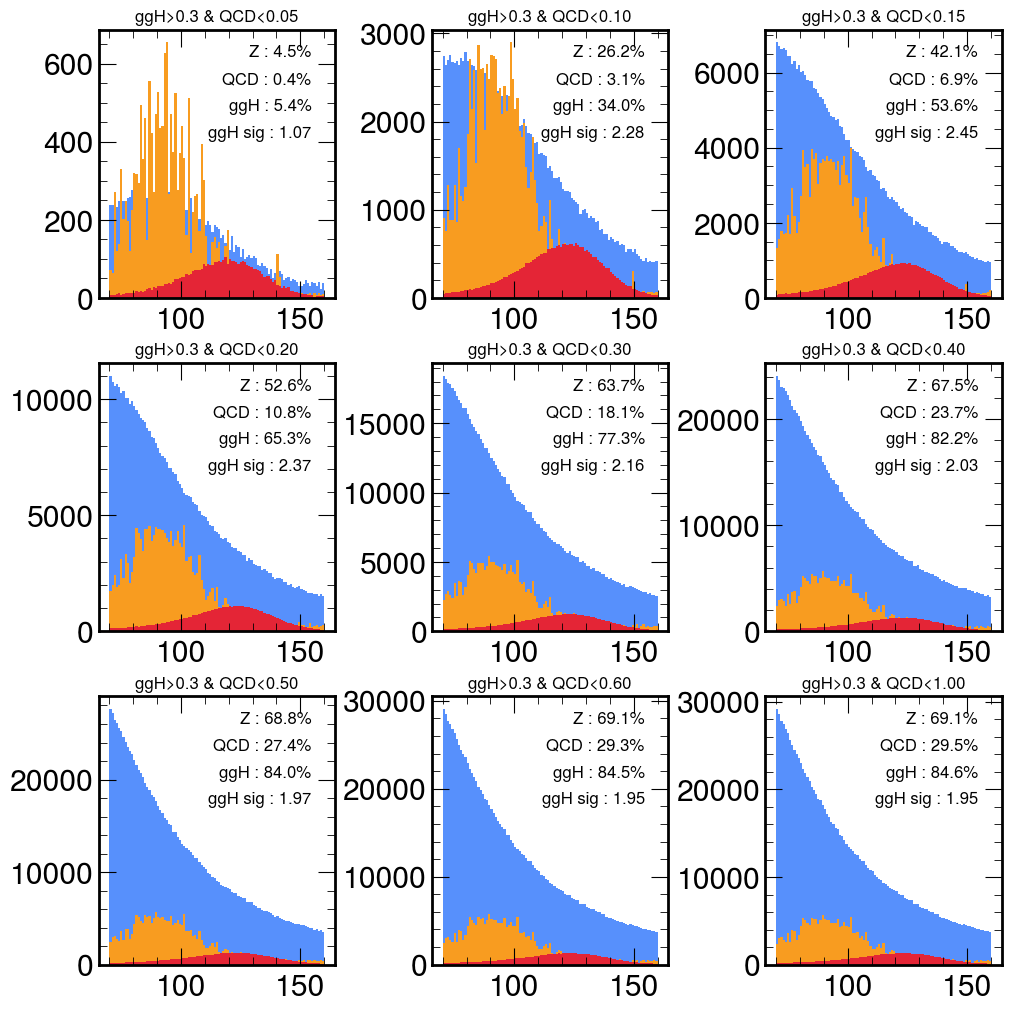

In [10]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)
massWindow_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindow_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
t = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.999]
ggH_threshold = 0.3
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,1]>ggH_threshold
        mask_H = YPred_H[:,1]>ggH_threshold
        mask_Z = YPred_Z[:,1]>ggH_threshold
        mask_data = (mask_data) & (YPred_data[:,0]<t[i*ncols+j])
        mask_H = (mask_H) & (YPred_H[:,0]<t[i*ncols+j])
        mask_Z = (mask_Z) & (YPred_Z[:,0]<t[i*ncols+j])
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z]*100)[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H]*1000)[0]

        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindow_H)])/np.sqrt(dfs[0][(mask_data) & (massWindow_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')

        ax[i,j].set_title("ggH>%.1f & QCD<%.2f"%(ggH_threshold,t[i*ncols+j]), fontsize=12)

In [11]:
sys.path.append('/t3home/gcelotto/ggHbb/scripts/plotScripts')
from plotFeatures import plotNormalizedFeatures
for ggH_threshold in np.linspace(0, 0.9, 10):
    #ggH_threshold=0.3
    qcd_threhsold = 0.15
    mask_data = YPred_data[:,1]>ggH_threshold
    mask_H = YPred_H[:,1]>ggH_threshold
    mask_Z = YPred_Z[:,1]>ggH_threshold
    mask_data = (mask_data) & (YPred_data[:,0]<qcd_threhsold)
    mask_H = (mask_H) & (YPred_H[:,0] < qcd_threhsold)
    mask_Z = (mask_Z) & (YPred_Z[:,0] < qcd_threhsold)
    #dfs[0]=dfs[0].drop('Muon_fired_HLT_Mu10p5_IP3p5', axis=1)
    #dfs[0]=dfs[0].drop('Muon_fired_HLT_Mu8p5_IP3p5', axis=1)
    #dfs[0]=dfs[0].drop('PU_sf', axis=1)
    plotNormalizedFeatures(data =   [dfs[0][mask_data],
                                 dfs[1][mask_H],
                                 dfs[2][mask_Z]],
                                outFile = "/t3home/gcelotto/ggHbb/NN/output/features_MultiClassCut%.1f.png"%(ggH_threshold),
                                legendLabels = ['Data', 'Higgs', 'Z'] , colors = ['blue', 'red', 'green'],
                                histtypes=[u'step', u'step', u'step'],
                                error=False,
                                weights=[np.ones(len(dfs[0]))[mask_data], W_H[mask_H], W_Z[mask_Z]],
                                figsize=(20, 30),
                                alphas=[1, 1, 1])

jet1_pt
jet1_eta
jet1_phi
jet1_mass
jet1_nMuons
jet1_nTightMuons
jet1_nElectrons
jet1_btagDeepFlavB
jet1_area
jet1_qgl
jet2_pt
jet2_eta
jet2_phi
jet2_mass
jet2_nMuons
jet2_nTightMuons
jet2_nElectrons
jet2_btagDeepFlavB
jet2_area
jet2_qgl
jet3_pt
jet3_eta
jet3_phi
jet3_mass
jet3_nTightMuons
jet3_btagDeepFlavB
jet3_btagDeepFlavC
jet3_qgl
dR_jet3_dijet
Feature dR_jet3_dijet not found. Binning Automatically defined
dijet_pt
dijet_eta
dijet_phi
dijet_mass
dijet_dR
dijet_dEta
dijet_dPhi
dijet_angVariable
dijet_twist
dijet_cs
nJets
nJets_20GeV
ht
muon_pt
muon_eta
muon_dxySig
muon_dzSig
muon_IP3d
muon_sIP3d
muon_tightId
muon_pfRelIso03_all


/t3home/gcelotto/ggHbb/scripts/plotScripts/plotFeatures.py:61: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  counts = np.histogram(np.clip(df[featureName], bins[0], bins[-1]),weights = weightsDf if featureName!='sf' else None, bins=bins)[0]


muon_pfRelIso04_all
muon_tkIsoId
Muon_fired_HLT_Mu12_IP6
Muon_fired_HLT_Mu7_IP4
Muon_fired_HLT_Mu8_IP3
Muon_fired_HLT_Mu8_IP5
Muon_fired_HLT_Mu8_IP6
Muon_fired_HLT_Mu9_IP4
Muon_fired_HLT_Mu9_IP5
Muon_fired_HLT_Mu9_IP6
PV_npvs
Pileup_nTrueInt
sf
Saving in /t3home/gcelotto/ggHbb/NN/output/features_MultiClassCut0.0.png
jet1_pt
jet1_eta
jet1_phi
jet1_mass
jet1_nMuons
jet1_nTightMuons
jet1_nElectrons
jet1_btagDeepFlavB
jet1_area
jet1_qgl
jet2_pt
jet2_eta
jet2_phi
jet2_mass
jet2_nMuons
jet2_nTightMuons
jet2_nElectrons
jet2_btagDeepFlavB
jet2_area
jet2_qgl
jet3_pt
jet3_eta
jet3_phi
jet3_mass
jet3_nTightMuons
jet3_btagDeepFlavB
jet3_btagDeepFlavC
jet3_qgl
dR_jet3_dijet
Feature dR_jet3_dijet not found. Binning Automatically defined
dijet_pt
dijet_eta
dijet_phi
dijet_mass
dijet_dR
dijet_dEta
dijet_dPhi
dijet_angVariable
dijet_twist
dijet_cs
nJets
nJets_20GeV
ht
muon_pt
muon_eta
muon_dxySig
muon_dzSig
muon_IP3d
muon_sIP3d
muon_tightId
muon_pfRelIso03_all
muon_pfRelIso04_all
muon_tkIsoId
Muon_fire